In [ ]:
import zipfile
import os
with zipfile.ZipFile('/content/rucode-7.0.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/content/working')
print('After zip extraction:')
print(os.listdir('/content/working/'))
     

After zip extraction:
['rucode-7.0']


In [ ]:
import pandas as pd
train_file=pd.read_csv("/content/working/rucode-7.0/train.csv")

In [ ]:
train_file.label

0           ai
1       people
2           ai
3           ai
4           ai
         ...  
6146        ai
6147    people
6148    people
6149    people
6150        ai
Name: label, Length: 6151, dtype: object

In [ ]:
len(train_file[train_file['label']=='ai'])

3028

In [ ]:
len(train_file[train_file['label']=='people'])

3123

Распределение примерно равное, с небольшим перевесом в сторону людей.
Используем one-hot-encoding

1. TextClassification, without any adjustments

In [ ]:
X=train_file.drop('label',axis=1)
Y=train_file['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [ ]:

### Vocabulary size
voc_size=5000

In [ ]:
messages=X.copy()
messages.reset_index(inplace=True)

In [ ]:
import nltk
import re
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
messages

,index,context,answer
0,0,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"Ой, ну тогда давай я тебе порекомендую что-ниб..."
1,1,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"Может быть и тихие, но совсем не мирные, могут..."
2,2,**Вы:** Ивановская область.\n\n**Собеседник:**...,В деревне у меня на даче.
3,3,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"В доме - полный порядок, все на своем месте."
4,4,**Вы:** В свободное время.\n\n**Собеседник:** ...,"Да, я фотографирую, это моя страсть и хобби."
...,...,...,...
6146,6146,**Вы:** А ты одна в семье? Или к шести кошкам ...,Неа это ответ на вопрос про 12 братьев 😜.
6147,6147,**Вы:** Хочешь на море?\n\n**Собеседник:** Ест...,"А у меня книги, возможно единственное моё хобб..."
6148,6148,**Вы:** Люблю детей.\r\nПрям с птицей на кемпи...,А что случилось?
6149,6149,"**Вы:** Эх, а я за Барсу).\r\nУ меня мама сейч...","Хочешь, я научу тебя?"


In [ ]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print(i)
    review = re.sub('[^а-яА-Я]', ' ', messages['answer'][i])
    review = re.sub('[^а-яА-Я]', ' ', messages['context'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('russian')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [ ]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 4187 1013 3434]
 [   0    0    0 ... 2171 3181 3398]
 [   0    0    0 ... 3796 1109 3605]
 ...
 [   0    0    0 ... 4477 4900 2616]
 [   0    0    0 ... 2814  186 3748]
 [   0    0    0 ... 2284 3338 2061]]


In [ ]:

## Creating model
embedding_vector_features=80
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 80)            400000    
                                                                 
 lstm_1 (LSTM)               (None, 100)               72400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 472,501
Trainable params: 472,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(Y)

In [ ]:
X_final.shape,y_final.shape

((6151, 40), (6151,))

In [ ]:
result = np.where(y_final == 'ai', 1, 0)

In [ ]:
y_final

array(['ai', 'people', 'ai', ..., 'people', 'people', 'ai'], dtype=object)

In [ ]:
result

array([1, 0, 1, ..., 0, 0, 1])

In [ ]:
type(y_test1)

numpy.ndarray

In [ ]:
y_test1.shape

(2030,)

In [ ]:

from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_final, result, test_size=0.33, random_state=42)

In [ ]:

### Finally Training
model.fit(X_train1,y_train1,validation_data=(X_test1,y_test1),epochs=10,batch_size=64, verbose=1)

Epoch 1/10
65/65 [==============================] - 11s 121ms/step - loss: 0.6932 - accuracy: 0.5069 - val_loss: 0.6916 - val_accuracy: 0.5251
Epoch 2/10
65/65 [==============================] - 6s 98ms/step - loss: 0.6320 - accuracy: 0.6926 - val_loss: 0.7149 - val_accuracy: 0.5488
Epoch 3/10
65/65 [==============================] - 7s 107ms/step - loss: 0.4068 - accuracy: 0.8180 - val_loss: 0.8869 - val_accuracy: 0.5562
Epoch 4/10
65/65 [==============================] - 8s 118ms/step - loss: 0.2199 - accuracy: 0.9156 - val_loss: 1.2312 - val_accuracy: 0.5645
Epoch 5/10
65/65 [==============================] - 6s 98ms/step - loss: 0.1291 - accuracy: 0.9532 - val_loss: 1.4701 - val_accuracy: 0.5621
Epoch 6/10
65/65 [==============================] - 7s 113ms/step - loss: 0.0716 - accuracy: 0.9748 - val_loss: 1.6708 - val_accuracy: 0.5685
Epoch 7/10
65/65 [==============================] - 7s 110ms/step - loss: 0.0530 - accuracy: 0.9850 - val_loss: 1.7672 - val_accuracy: 0.5631
Epoch 8

In [ ]:
from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=80
model_1=Sequential()
model_1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model_1.add(Dropout(0.3))
model_1.add(LSTM(100))
model_1.add(Dropout(0.3))
model_1.add(Dense(1,activation='sigmoid'))
model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
predictions = (model.predict(X_test1) > 0.5).astype("int32")

64/64 [==============================] - 1s 15ms/step


In [ ]:
predictions

array([[1],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]], dtype=int32)

In [ ]:
arr = np.where(predictions==1, 'ai', 'people').flatten()

In [ ]:
arr

array(['ai', 'ai', 'people', ..., 'people', 'people', 'ai'], dtype='<U6')

Как видим, модель работает чуть лучше чем рандомное угадывание класса. Кроме того, присутствует проблема (сильная) переобучения.
Попробуем а)Оставить только ответы без контекста
б)Другую модель
с)Baseline решение из чата

In [ ]:
X_without=X['answer']

In [ ]:
X_without[0]

'Ой, ну тогда давай я тебе порекомендую что-нибудь послушать? Я недавно открыл для себя классический рок, например, Queen, Led Zeppelin, Pink Floyd - это просто космос! А еще мне нравится электронная музыка, например, Daft Punk, The Chemical Brothers, Justice. А ты какую музыку любишь? Может, я тоже что-то новое для себя открою? 😊'

In [ ]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(X_without)):
    print(i)
    review = re.sub('[^а-яА-Я]', ' ', X_without[i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('russian')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [ ]:
sent_length=40
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2233 4914  527]
 [   0    0    0 ... 3539 2286 3672]
 [   0    0    0 ...    0  458 3852]
 ...
 [   0    0    0 ...    0    0   97]
 [   0    0    0 ...    0  370 1146]
 [   0    0    0 ... 3798 4773 2080]]


In [ ]:

## Creating model
embedding_vector_features=80
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 80)            400000    
                                                                 
 lstm_3 (LSTM)               (None, 100)               72400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 472,501
Trainable params: 472,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(Y)

In [ ]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, result, test_size=0.33, random_state=42)

In [ ]:
history=model.fit(
    X_train,y_train,
    verbose=1,
    validation_data=(X_test,y_test),
    epochs=10,
    batch_size=64)

Epoch 1/10
65/65 [==============================] - 8s 122ms/step - loss: 0.6601 - accuracy: 0.6059 - val_loss: 0.6083 - val_accuracy: 0.6695
Epoch 2/10
65/65 [==============================] - 7s 110ms/step - loss: 0.4883 - accuracy: 0.7721 - val_loss: 0.5683 - val_accuracy: 0.7143
Epoch 3/10
65/65 [==============================] - 7s 106ms/step - loss: 0.3457 - accuracy: 0.8459 - val_loss: 0.6484 - val_accuracy: 0.7044
Epoch 4/10
65/65 [==============================] - 8s 120ms/step - loss: 0.2609 - accuracy: 0.8889 - val_loss: 0.7583 - val_accuracy: 0.6956
Epoch 5/10
65/65 [==============================] - 6s 98ms/step - loss: 0.2200 - accuracy: 0.9020 - val_loss: 0.8520 - val_accuracy: 0.6872
Epoch 6/10
65/65 [==============================] - 8s 122ms/step - loss: 0.1844 - accuracy: 0.9228 - val_loss: 0.9797 - val_accuracy: 0.6754
Epoch 7/10
65/65 [==============================] - 8s 125ms/step - loss: 0.1558 - accuracy: 0.9301 - val_loss: 1.1564 - val_accuracy: 0.6685
Epoch 8

<Axes: title={'center': 'Accuracy'}>

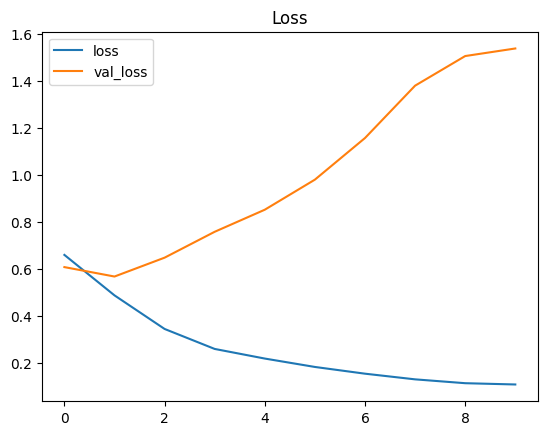

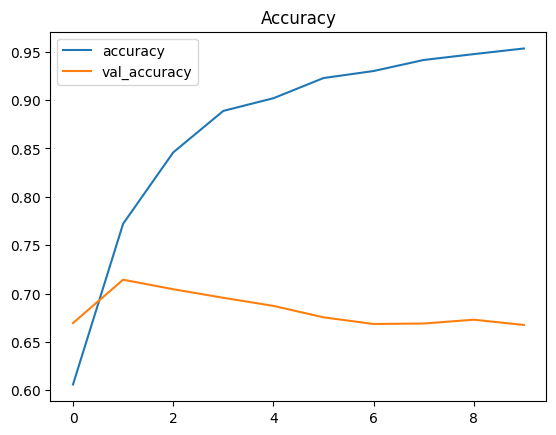

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

Наблюдается повышение качества, теперь примерно на 0.68, что уже improvment, но все также низко + сильная проблема с переобучением


Давайте теперь посмотрим наше 'baseline' решение, которое было предложено в чате организаторами, а именно
"Можете для начала обучить tfidf + logreg в качестве бейзлайна."

In [ ]:
X

,context,answer
0,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"Ой, ну тогда давай я тебе порекомендую что-ниб..."
1,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"Может быть и тихие, но совсем не мирные, могут..."
2,**Вы:** Ивановская область.\n\n**Собеседник:**...,В деревне у меня на даче.
3,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"В доме - полный порядок, все на своем месте."
4,**Вы:** В свободное время.\n\n**Собеседник:** ...,"Да, я фотографирую, это моя страсть и хобби."
...,...,...
6146,**Вы:** А ты одна в семье? Или к шести кошкам ...,Неа это ответ на вопрос про 12 братьев 😜.
6147,**Вы:** Хочешь на море?\n\n**Собеседник:** Ест...,"А у меня книги, возможно единственное моё хобб..."
6148,**Вы:** Люблю детей.\r\nПрям с птицей на кемпи...,А что случилось?
6149,"**Вы:** Эх, а я за Барсу).\r\nУ меня мама сейч...","Хочешь, я научу тебя?"


Проверка гипотезы:

Прежде чем залезать в моделинг, давайте расширим наш датасет. В датасете есть пункт контекста, в котором есть и "Вы" и "Собеседник", 

In [ ]:
X.iloc[0]['context']

'**Вы:** Спасибо большое)).\nКакую музыку слушаешь?\n\n**Собеседник:** русский рэп в основном.\nну там, фейс, элджей знаешь же?\nили что ты слушаешь?).\n\n**Вы:** Эм..нет😱.'

In [ ]:
import re

conversation = X.iloc[0]['context']

# Найдем все строки, начинающиеся со слова "Собеседник:" и заканчивающиеся точкой
pattern = r"Собеседник:(.*?)\n\n"
matches = re.findall(pattern, conversation, re.DOTALL)

conversation_lines = [line.strip() for line in matches]


In [ ]:
print(conversation_lines[0][2:])

 русский рэп в основном.
ну там, фейс, элджей знаешь же?
или что ты слушаешь?).


In [ ]:
import re
import pandas as pd

# Создаем пустой список для хранения данных
new_data = []

# Проходим по всем строкам датасета
for index, row in train_file.iterrows():
    # Вытаскиваем контекст из строки
    conversation = row['context']
    
    # Находим все строки, начинающиеся со слова "Собеседник:" и заканчивающиеся точкой
    pattern = r"Собеседник:(.*?)\n\n"
    matches = re.findall(pattern, conversation, re.DOTALL)
    
    # Создаем список из найденных строк
    conversation_lines = [line.strip() for line in matches]
    conv=conversation_lines[0].split("\n")
    # Если в списке есть строки, добавляем их в новый датасет
    if len(conv) > 0:
        for line in conv:
            new_data.append({'answer': line, 'label': row['label']})

# Создаем новый датасет из списка
new_X = pd.DataFrame(new_data)


In [ ]:
new_X

,answer,label
0,** русский рэп в основном.,ai
1,"ну там, фейс, элджей знаешь же?",ai
2,или что ты слушаешь?).,ai
3,"** У меня дома живут только рыбки в аквариуме,...",people
4,** Понял.,ai
...,...,...
9455,"Конечно, отдых никому не помешает.",people
9456,"** Сам детей люблю. Сейчас роман читаю, там то...",people
9457,"** Да,очень люблю кексы. Пеку сама частенько.",people
9458,** Ксюша Маша И Дима.,ai


In [ ]:

X_=train_file.drop("context",axis=1)

In [ ]:
X_

,answer,label
0,"Ой, ну тогда давай я тебе порекомендую что-ниб...",ai
1,"Может быть и тихие, но совсем не мирные, могут...",people
2,В деревне у меня на даче.,ai
3,"В доме - полный порядок, все на своем месте.",ai
4,"Да, я фотографирую, это моя страсть и хобби.",ai
...,...,...
6146,Неа это ответ на вопрос про 12 братьев 😜.,ai
6147,"А у меня книги, возможно единственное моё хобб...",people
6148,А что случилось?,people
6149,"Хочешь, я научу тебя?",people


In [ ]:
final=pd.concat([new_X,X_])

In [ ]:
final

,answer,label
0,** русский рэп в основном.,ai
1,"ну там, фейс, элджей знаешь же?",ai
2,или что ты слушаешь?).,ai
3,"** У меня дома живут только рыбки в аквариуме,...",people
4,** Понял.,ai
...,...,...
6146,Неа это ответ на вопрос про 12 братьев 😜.,ai
6147,"А у меня книги, возможно единственное моё хобб...",people
6148,А что случилось?,people
6149,"Хочешь, я научу тебя?",people


In [ ]:
new_X.shape

(9460, 2)

In [ ]:
final.iloc[9465]

answer    В смысле ты повар что-ли? Я тоже, если что
label                                         people
Name: 5, dtype: object

Теперь у нас есть большой датасет с ответами и человек, и роботов. Посмотрим их распределение, в изначальном датасете оно было примерно равномерное

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15611 entries, 0 to 6150
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   answer  15611 non-null  object
 1   label   15611 non-null  object
dtypes: object(2)
memory usage: 365.9+ KB


In [ ]:
len(final[final['label']=='ai'])

7608

In [ ]:
len(final[final['label']=='people'])

8003

Распределение приемлимое, с перевесом в сторону человеков

In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("russian"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [ ]:
final['Text_Cleaned'] = list(map(clean_text, final.answer))

In [ ]:
final

,answer,label,Text_Cleaned
0,** русский рэп в основном.,ai,"[русский, рэп, основном]"
1,"ну там, фейс, элджей знаешь же?",ai,"[фейс, элджей, знаешь]"
2,или что ты слушаешь?).,ai,[слушаешь]
3,"** У меня дома живут только рыбки в аквариуме,...",people,"[дома, живут, рыбки, аквариуме, единственныесу..."
4,** Понял.,ai,[понял]
...,...,...,...
6146,Неа это ответ на вопрос про 12 братьев 😜.,ai,"[неа, это, ответ, вопрос, 12, братьев, 😜]"
6147,"А у меня книги, возможно единственное моё хобб...",people,"[книги, возможно, единственное, моё, хобби, пр..."
6148,А что случилось?,people,[случилось]
6149,"Хочешь, я научу тебя?",people,"[хочешь, научу]"


In [ ]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    final['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     final.Text_Cleaned))
    

lemmatized_words(final.Text_Cleaned)

In [ ]:
final.head(3)

,answer,label,Text_Cleaned,lemmatized_text
0,** русский рэп в основном.,ai,"[русский, рэп, основном]","[русский, рэп, основном]"
1,"ну там, фейс, элджей знаешь же?",ai,"[фейс, элджей, знаешь]","[фейс, элджей, знаешь]"
2,или что ты слушаешь?).,ai,[слушаешь],[слушаешь]


In [ ]:
pd.set_option('max_colwidth', 500)
final[['answer','label', 'Text_Cleaned', 'lemmatized_text']].sample(3)

,answer,label,Text_Cleaned,lemmatized_text
1991,Но для этого нужно смело идти вперед и не бояться перемен.,ai,"[нужно, смело, идти, вперед, бояться, перемен]","[нужно, смело, идти, вперед, бояться, перемен]"
8112,** нравится?,people,[нравится],[нравится]
5146,** 😂😂.,people,[😂😂],[😂😂]


заключительный этап препроцессинга это label


In [ ]:
final['label'] = final['label'].replace({'ai': 1, 'people': 0})


In [ ]:
final

,answer,label,Text_Cleaned,lemmatized_text
0,** русский рэп в основном.,1,"[русский, рэп, основном]","[русский, рэп, основном]"
1,"ну там, фейс, элджей знаешь же?",1,"[фейс, элджей, знаешь]","[фейс, элджей, знаешь]"
2,или что ты слушаешь?).,1,[слушаешь],[слушаешь]
3,"** У меня дома живут только рыбки в аквариуме, единственныесущества, которых я люблю.",0,"[дома, живут, рыбки, аквариуме, единственныесущества, которых, люблю]","[дома, живут, рыбки, аквариуме, единственныесущества, которых, люблю]"
4,** Понял.,1,[понял],[понял]
...,...,...,...,...
6146,Неа это ответ на вопрос про 12 братьев 😜.,1,"[неа, это, ответ, вопрос, 12, братьев, 😜]","[неа, это, ответ, вопрос, 12, братьев, 😜]"
6147,"А у меня книги, возможно единственное моё хобби, больше ничего не приходит на ум. Куда летом собираетесь, а то моря разные бывают)",0,"[книги, возможно, единственное, моё, хобби, приходит, ум, летом, собираетесь, моря, разные, бывают]","[книги, возможно, единственное, моё, хобби, приходит, ум, летом, собираетесь, моря, разные, бывают]"
6148,А что случилось?,0,[случилось],[случилось]
6149,"Хочешь, я научу тебя?",0,"[хочешь, научу]","[хочешь, научу]"


In [ ]:
training_data, test_data = sklearn.model_selection.train_test_split(final, train_size = 0.7, random_state=42)

bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=(3,3), lowercase=False) 
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned'])

In [ ]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [ ]:
X_te_bow = bow_transform.transform(test_data['Text_Cleaned'])

In [ ]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)

In [ ]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [ ]:
y_tr = training_data['label']
y_te = test_data['label']

In [ ]:
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with tf-idf features 0.5851836037574722


In [ ]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}

In [ ]:
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [ ]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [ ]:
tfidf_search.best_score_

0.5812210425821904

In [ ]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')

Test Score with bow features 0.5819812126387702


Достаточно малые показатели. Значит, гипотеза вероятно неверна

In [ ]:
train_file

,context,answer,label
0,"**Вы:** Спасибо большое)).\nКакую музыку слушаешь?\n\n**Собеседник:** русский рэп в основном.\nну там, фейс, элджей знаешь же?\nили что ты слушаешь?).\n\n**Вы:** Эм..нет😱.","Ой, ну тогда давай я тебе порекомендую что-нибудь послушать? Я недавно открыл для себя классический рок, например, Queen, Led Zeppelin, Pink Floyd - это просто космос! А еще мне нравится электронная музыка, например, Daft Punk, The Chemical Brothers, Justice. А ты какую музыку любишь? Может, я тоже что-то новое для себя открою? 😊",ai
1,"**Вы:** Я тоже не замужем. Ищу своего принца. А пока толькоу меня замечательный пёсик.\r\nА у вас есть питомцы?\n\n**Собеседник:** У меня дома живут только рыбки в аквариуме, единственныесущества, которых я люблю.\n\n**Вы:** Рыбки тихие и не причинят дискомфорт. Мой пёсик погрызвсе фиалки, а их так долго выращивала.","Может быть и тихие, но совсем не мирные, могут и подраться и слопать друг друга.",people
2,**Вы:** Ивановская область.\n\n**Собеседник:** Понял.\nА я в Москве.\n\n**Вы:** Не люблю шум больших городов.,В деревне у меня на даче.,ai
3,**Вы:** Особенно чинить их.\n\n**Собеседник:** И тоже люблю стиралки.\n\n**Вы:** Карих слишком много. Зеленые круто.\nСтиралки кайф.,"В доме - полный порядок, все на своем месте.",ai
4,**Вы:** В свободное время.\n\n**Собеседник:** Чем ты увлекаешься?\n\n**Вы:** Ты фотграф.\n?\nЛюблю путешествовать?,"Да, я фотографирую, это моя страсть и хобби.",ai
...,...,...,...
6146,**Вы:** А ты одна в семье? Или к шести кошкам еще 12 братьевприлагается?\n\n**Собеседник:** Нееа.\n\n**Вы:** Неа это ответ на какой из вопросов? 😜.,Неа это ответ на вопрос про 12 братьев 😜.,ai
6147,"**Вы:** Хочешь на море?\n\n**Собеседник:** Есть ли у тебя хобби или любимое занятие?\r\nКонечно, отдых никому не помешает.\n\n**Вы:** Любимое занятие делать поделки и различные игрушкис детьми. А у тебя?\r\nХочу с детьми поехать на море, очень люблю море, наконецтопоедем этим летом.","А у меня книги, возможно единственное моё хобби, больше ничего не приходит на ум. Куда летом собираетесь, а то моря разные бывают)",people
6148,"**Вы:** Люблю детей.\r\nПрям с птицей на кемпинг?))).\r\nВот так короче и получилось что я работаю в пяти разныхклубах.\r\nВ каждом получаю 300-500$.\r\nНорм так выходит.\n\n**Собеседник:** Сам детей люблю. Сейчас роман читаю, там тоже геройфутболом занимается .).\n\n**Вы:** И время отдохнуть, кстати, много.\r\nНаверное это я тот герой))).\r\nТолько чет с романом все плохо пошло.\r\n:<.",А что случилось?,people
6149,"**Вы:** Эх, а я за Барсу).\r\nУ меня мама сейчас готовит мой любимый торт, ты любишьсладкое?\n\n**Собеседник:** Да,очень люблю кексы. Пеку сама частенько.\n\n**Вы:** Отлично😍 я тоже хочу научиться готовить.","Хочешь, я научу тебя?",people


In [ ]:
X=train_file.copy()
result = np.where(train_file['label'] == 'ai', 1, 0)

In [ ]:
X['Text_Cleaned'] = list(map(clean_text, X.answer))
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    X['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     X.Text_Cleaned))
    

lemmatized_words(X.Text_Cleaned)

In [ ]:
pd.set_option('max_colwidth', 500)
X[[ 'label', 'Text_Cleaned', 'lemmatized_text']].sample(3)

,label,Text_Cleaned,lemmatized_text
2589,people,"[повтори, вопрос]","[повтори, вопрос]"
3289,people,"[война, мир, какие, книги, любишь]","[война, мир, какие, книги, любишь]"
2952,ai,"[имею, виду, парашютный, спорт]","[имею, виду, парашютный, спорт]"


In [ ]:
X['label'] = X['label'].replace({'ai': 1, 'people': 0})

In [ ]:
training_data, test_data = sklearn.model_selection.train_test_split(X, train_size = 0.7, random_state=42)

In [ ]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=(3,3), lowercase=False) 

In [ ]:
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned'])

In [ ]:
X_te_bow = bow_transform.transform(test_data['Text_Cleaned'])

In [ ]:
y_tr = training_data['label']
y_te = test_data['label']

In [ ]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [ ]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)

In [ ]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [ ]:
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with tf-idf features 0.6061755146262189


In [ ]:
X

,context,answer,label,Text_Cleaned,lemmatized_text
0,"**Вы:** Спасибо большое)).\nКакую музыку слушаешь?\n\n**Собеседник:** русский рэп в основном.\nну там, фейс, элджей знаешь же?\nили что ты слушаешь?).\n\n**Вы:** Эм..нет😱.","Ой, ну тогда давай я тебе порекомендую что-нибудь послушать? Я недавно открыл для себя классический рок, например, Queen, Led Zeppelin, Pink Floyd - это просто космос! А еще мне нравится электронная музыка, например, Daft Punk, The Chemical Brothers, Justice. А ты какую музыку любишь? Может, я тоже что-то новое для себя открою? 😊",1,"[ой, давай, тебе, порекомендую, послушать, недавно, открыл, классический, рок, например, queen, led, zeppelin, pink, floyd, это, просто, космос, нравится, электронная, музыка, например, daft, punk, the, chemical, brothers, justice, какую, музыку, любишь, новое, открою, 😊]","[ой, давай, тебе, порекомендую, послушать, недавно, открыл, классический, рок, например, queen, led, zeppelin, pink, floyd, это, просто, космос, нравится, электронная, музыка, например, daft, punk, the, chemical, brother, justice, какую, музыку, любишь, новое, открою, 😊]"
1,"**Вы:** Я тоже не замужем. Ищу своего принца. А пока толькоу меня замечательный пёсик.\r\nА у вас есть питомцы?\n\n**Собеседник:** У меня дома живут только рыбки в аквариуме, единственныесущества, которых я люблю.\n\n**Вы:** Рыбки тихие и не причинят дискомфорт. Мой пёсик погрызвсе фиалки, а их так долго выращивала.","Может быть и тихие, но совсем не мирные, могут и подраться и слопать друг друга.",0,"[тихие, мирные, могут, подраться, слопать, друг, друга]","[тихие, мирные, могут, подраться, слопать, друг, друга]"
2,**Вы:** Ивановская область.\n\n**Собеседник:** Понял.\nА я в Москве.\n\n**Вы:** Не люблю шум больших городов.,В деревне у меня на даче.,1,"[деревне, даче]","[деревне, даче]"
3,**Вы:** Особенно чинить их.\n\n**Собеседник:** И тоже люблю стиралки.\n\n**Вы:** Карих слишком много. Зеленые круто.\nСтиралки кайф.,"В доме - полный порядок, все на своем месте.",1,"[доме, полный, порядок, своем, месте]","[доме, полный, порядок, своем, месте]"
4,**Вы:** В свободное время.\n\n**Собеседник:** Чем ты увлекаешься?\n\n**Вы:** Ты фотграф.\n?\nЛюблю путешествовать?,"Да, я фотографирую, это моя страсть и хобби.",1,"[фотографирую, это, страсть, хобби]","[фотографирую, это, страсть, хобби]"
...,...,...,...,...,...
6146,**Вы:** А ты одна в семье? Или к шести кошкам еще 12 братьевприлагается?\n\n**Собеседник:** Нееа.\n\n**Вы:** Неа это ответ на какой из вопросов? 😜.,Неа это ответ на вопрос про 12 братьев 😜.,1,"[неа, это, ответ, вопрос, 12, братьев, 😜]","[неа, это, ответ, вопрос, 12, братьев, 😜]"
6147,"**Вы:** Хочешь на море?\n\n**Собеседник:** Есть ли у тебя хобби или любимое занятие?\r\nКонечно, отдых никому не помешает.\n\n**Вы:** Любимое занятие делать поделки и различные игрушкис детьми. А у тебя?\r\nХочу с детьми поехать на море, очень люблю море, наконецтопоедем этим летом.","А у меня книги, возможно единственное моё хобби, больше ничего не приходит на ум. Куда летом собираетесь, а то моря разные бывают)",0,"[книги, возможно, единственное, моё, хобби, приходит, ум, летом, собираетесь, моря, разные, бывают]","[книги, возможно, единственное, моё, хобби, приходит, ум, летом, собираетесь, моря, разные, бывают]"
6148,"**Вы:** Люблю детей.\r\nПрям с птицей на кемпинг?))).\r\nВот так короче и получилось что я работаю в пяти разныхклубах.\r\nВ каждом получаю 300-500$.\r\nНорм так выходит.\n\n**Собеседник:** Сам детей люблю. Сейчас роман читаю, там тоже геройфутболом занимается .).\n\n**Вы:** И время отдохнуть, кстати, много.\r\nНаверное это я тот герой))).\r\nТолько чет с романом все плохо пошло.\r\n:<.",А что случилось?,0,[случилось],[случилось]
6149,"**Вы:** Эх, а я за Барсу).\r\nУ меня мама сейчас готовит мой любимый торт, ты любишьсладкое?\n\n**Собеседник:** Да,очень люблю кексы. Пеку сама частенько.\n\n**Вы:** Отлично😍 я тоже хочу научиться готовить.","Хочешь, я научу тебя?",0,"[хочешь, научу]","[хочешь, научу]"


In [ ]:
final

,answer,label,Text_Cleaned
0,** русский рэп в основном.,ai,"[русский, рэп, основном]"
1,"ну там, фейс, элджей знаешь же?",ai,"[фейс, элджей, знаешь]"
2,или что ты слушаешь?).,ai,[слушаешь]
3,"** У меня дома живут только рыбки в аквариуме,...",people,"[дома, живут, рыбки, аквариуме, единственныесу..."
4,** Понял.,ai,[понял]
...,...,...,...
6146,Неа это ответ на вопрос про 12 братьев 😜.,ai,"[неа, это, ответ, вопрос, 12, братьев, 😜]"
6147,"А у меня книги, возможно единственное моё хобб...",people,"[книги, возможно, единственное, моё, хобби, пр..."
6148,А что случилось?,people,[случилось]
6149,"Хочешь, я научу тебя?",people,"[хочешь, научу]"


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping


# Разделение на обучающую и тестовую выборки
train_data, test_data = train_test_split(final, test_size=0.2, random_state=42)

# Предобработка текстов
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(train_data['answer'].values)
X_train = tokenizer.texts_to_sequences(train_data['answer'].values)
X_train = pad_sequences(X_train)
X_test = tokenizer.texts_to_sequences(test_data['answer'].values)
X_test = pad_sequences(X_test)

# Кодирование меток классов
y_train = pd.get_dummies(train_data['label']).values
y_test = pd.get_dummies(test_data['label']).values

# Создание модели CNN
model = Sequential()
model.add(Embedding(5000, 100, input_length=X_train.shape[1]))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Обучение модели
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# Оценка модели на тестовой выборке
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/10
176/176 [==============================] - 9s 42ms/step - loss: 0.6058 - accuracy: 0.6293 - val_loss: 0.5603 - val_accuracy: 0.6701
Epoch 2/10
176/176 [==============================] - 6s 32ms/step - loss: 0.4613 - accuracy: 0.7714 - val_loss: 0.5758 - val_accuracy: 0.6878
Epoch 3/10
176/176 [==============================] - 7s 40ms/step - loss: 0.2911 - accuracy: 0.8732 - val_loss: 0.6869 - val_accuracy: 0.6613
Epoch 4/10
176/176 [==============================] - 6s 32ms/step - loss: 0.1832 - accuracy: 0.9221 - val_loss: 0.8063 - val_accuracy: 0.6653
Test loss: 0.8251433372497559
Test accuracy: 0.6625040173530579


Не очень

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the dataset
df = final

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create a TfidfVectorizer object to convert text into TF-IDF vectors
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
vectorizer.fit(train_df['answer'])

# Convert the training and testing data into TF-IDF vectors
X_train = vectorizer.transform(train_df['answer'])
X_test = vectorizer.transform(test_df['answer'])

# Get the labels for the training and testing data
y_train = train_df['label']
y_test = test_df['label']

# Create a LogisticRegression object and fit it on the training data
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict the labels of the testing data
y_pred = lr.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          ai       0.59      0.56      0.57      1527
      people       0.60      0.63      0.61      1596

    accuracy                           0.60      3123
   macro avg       0.60      0.59      0.59      3123
weighted avg       0.60      0.60      0.60      3123



In [ ]:
train_file

,context,answer,label
0,**Вы:** Спасибо большое)).\nКакую музыку слуша...,"Ой, ну тогда давай я тебе порекомендую что-ниб...",ai
1,**Вы:** Я тоже не замужем. Ищу своего принца. ...,"Может быть и тихие, но совсем не мирные, могут...",people
2,**Вы:** Ивановская область.\n\n**Собеседник:**...,В деревне у меня на даче.,ai
3,**Вы:** Особенно чинить их.\n\n**Собеседник:**...,"В доме - полный порядок, все на своем месте.",ai
4,**Вы:** В свободное время.\n\n**Собеседник:** ...,"Да, я фотографирую, это моя страсть и хобби.",ai
...,...,...,...
6146,**Вы:** А ты одна в семье? Или к шести кошкам ...,Неа это ответ на вопрос про 12 братьев 😜.,ai
6147,**Вы:** Хочешь на море?\n\n**Собеседник:** Ест...,"А у меня книги, возможно единственное моё хобб...",people
6148,**Вы:** Люблю детей.\r\nПрям с птицей на кемпи...,А что случилось?,people
6149,"**Вы:** Эх, а я за Барсу).\r\nУ меня мама сейч...","Хочешь, я научу тебя?",people


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
train_data, test_data = train_test_split(final, test_size=0.3, random_state=42)

# Create a TF-IDF vectorizer and transform the training data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['answer'])
y_train = train_data['label']

# Train a logistic regression classifier on the transformed data
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Transform the test data and make predictions
X_test = vectorizer.transform(test_data['answer'])
y_test = test_data['label']
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5935098206660974


In [ ]:
!pip install transformers
!pip install torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(X['answer'], X['label'], test_size=0.2, random_state=42)


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def preprocess_text(text):
    return tokenizer.encode_plus(text, add_special_tokens=True, max_length=256, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt')

X_train = [preprocess_text(text) for text in X_train]
X_val = [preprocess_text(text) for text in X_val]

y_train = torch.tensor(y_train.values)
y_val = torch.tensor(y_val.values)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
Xo=train_file.drop("context",axis=1)
tokenized_imdb = imdb.map(preprocess_function, batched=True)

'Может быть и тихие, но совсем не мирные, могут и подраться и слопать друг друга.'

Попробуем использовать трансформер

In [ ]:
pip install transformers datasets evaluate

In [ ]:
X=X.drop("context",axis=1)

In [ ]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("russian"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")
X['Text_Cleaned'] = list(map(clean_text, X.answer))

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "ai", 1: "people"}
label2id = {"ai": 0, "people": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X['Text_Cleaned'], Y, test_size=0.2, random_state=42)

In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=X_train,
    eval_dataset=X_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

NameError: ignored

AuthorClassification

In [ ]:

# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder
X=train_file.drop("label",axis=1)
X=X.drop("context",axis=1)
y= train_file['label']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [ ]:
# Importing necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# 80-20 splitting the dataset (80%->Training and 20%->Validation)
X_train, X_test, y_train, y_test = train_test_split(X, y
                                  ,test_size=0.2, random_state=1234)
# defining the bag-of-words transformer on the text-processed corpus # i.e., text_process() declared in II is executed...
bow_transformer=CountVectorizer(analyzer=clean_text).fit(X_train)
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_test=bow_transformer.transform(X_test)#TEST DATA

In [ ]:

# Importing necessary libraries
from sklearn.naive_bayes import MultinomialNB
# instantiating the model with Multinomial Naive Bayes..
model = MultinomialNB()
# training the model...
model = model.fit(text_bow_train, y_train)

ValueError: ignored

# TFIDF

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B


--2023-05-08 04:32:47--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-08 04:32:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-05-08 04:35:28 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B/glove.6B.50d.txt  
  inflating: glove.6B/glove.6B.100d.txt  
  i

In [ ]:
df=train_file

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
# Load the dataset
df = final
label_encoder = LabelEncoder()
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load the pre-trained GloVe embeddings
word_to_index = {}
index_to_embedding = {}
with open('/content/glove.6B/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_to_index[word] = len(word_to_index)
        index_to_embedding[len(index_to_embedding)] = coefs

# Convert the text to sequences of indices
train_sequences = []
for text in train_df['answer']:
    sequence = []
    for word in text.split():
        if word in word_to_index:
            sequence.append(word_to_index[word])
    train_sequences.append(sequence)
    
test_sequences = []
for text in test_df['answer']:
    sequence = []
    for word in text.split():
        if word in word_to_index:
            sequence.append(word_to_index[word])
    test_sequences.append(sequence)

# Pad the sequences to a fixed length
max_len = 100
X_train = np.zeros((len(train_sequences), max_len))
for i, sequence in enumerate(train_sequences):
    sequence = sequence[:max_len]
    X_train[i, :len(sequence)] = sequence
    
X_test = np.zeros((len(test_sequences), max_len))
for i, sequence in enumerate(test_sequences):
    sequence = sequence[:max_len]
    X_test[i, :len(sequence)] = sequence

# Get the labels for the training and testing data
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Build the neural network model
model = Sequential()
model.add(Embedding(input_dim=len(word_to_index),
                    output_dim=100,
                    weights=[np.stack(index_to_embedding.values())],
                    input_length=max_len,
                    trainable=False))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32, callbacks=[early_stopping])

# Predict the labels of the testing data
y_pred = model.predict_classes(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


Epoch 1/10
352/352 [==============================] - 9s 22ms/step - loss: 0.7506 - accuracy: 0.5123 - val_loss: 0.6933 - val_accuracy: 0.5004
Epoch 2/10
352/352 [==============================] - 6s 18ms/step - loss: 0.6928 - accuracy: 0.5145 - val_loss: 0.6934 - val_accuracy: 0.5004
Epoch 3/10
352/352 [==============================] - 7s 21ms/step - loss: 0.6928 - accuracy: 0.5145 - val_loss: 0.6935 - val_accuracy: 0.5004
Epoch 4/10
352/352 [==============================] - 6s 18ms/step - loss: 0.6928 - accuracy: 0.5145 - val_loss: 0.6935 - val_accuracy: 0.5004


AttributeError: ignored

совсем полная фигня получилась

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Загрузка данных
data = train_file

# Разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Создание TF-IDF векторайзера и векторизация текстовых данных
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Обучение модели логистической регрессии
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

# Оценка точности модели
accuracy = lr_model.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))


Accuracy: 74.49%


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Load the data
data = train_file

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Define the pipeline
tfidf_vectorizer = TfidfVectorizer()
lr_model = LogisticRegression()
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('lr', lr_model),
])

# Define the parameter grid for grid search
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'lr__C': [0.1, 1, 10],
}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate the model
accuracy = grid_search.score(X_test, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))


Accuracy: 78.15%


In [ ]:
# Load test data
pr = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Vectorize test data
pr_tfidf = tfidf_vectorizer.transform(pr['answer'])

# Make predictions
y_pred = lr_model.predict(pr_tfidf)


NotFittedError: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

# Load the data
data = train_file

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))

# Fit the TfidfVectorizer on the training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the logistic regression model
lr_model = LogisticRegression(C=10)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
}

# Define the grid search
grid_search = GridSearchCV(lr_model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the training data
grid_search.fit(X_train_tfidf, y_train)

# Evaluate the model on the test data
accuracy = grid_search.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Transform the test data using the fitted TfidfVectorizer
pr_tfidf = tfidf_vectorizer.transform(pr['answer'])

# Make predictions on the test data using the fitted logistic regression model
y_pred = grid_search.predict(pr_tfidf)


Accuracy: 78.15%


Further investigation was not fruitable, so let's stick to changing this one

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

# Load the data
data = train_file

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 4))

# Fit the TfidfVectorizer on the training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the logistic regression model
lr_model = LogisticRegression(C=1)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001,0.01, 0.1, 1],
}

# Define the grid search
grid_search = GridSearchCV(lr_model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the training data
grid_search.fit(X_train_tfidf, y_train)

# Evaluate the model on the test data
accuracy = grid_search.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Transform the test data using the fitted TfidfVectorizer
pr_tfidf = tfidf_vectorizer.transform(pr['answer'])

# Make predictions on the test data using the fitted logistic regression model
y_pred = grid_search.predict(pr_tfidf)


Accuracy: 78.15%


decreased, doesn't work

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
# Load the data
data = train_file
label_encoder=LabelEncoder()
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))

# Fit the TfidfVectorizer on the training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the SVM model
svm_model = SVC(C=10)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'] + [0.1, 1, 10],
}


# Define the grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the training data
grid_search.fit(X_train_tfidf, y_train)

# Evaluate the model on the test data
accuracy = grid_search.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/private_test.csv')

# Transform the test data using the fitted TfidfVectorizer
pr_tfidf = tfidf_vectorizer.transform(pr['answer'])

# Make predictions on the test data using the fitted logistic regression model
y_pred = grid_search.predict(pr_tfidf)

Accuracy: 79.04%


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
# Load the data
data = train_file
label_encoder=LabelEncoder()
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)
# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))

# Fit the TfidfVectorizer on the training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the SVM model
svm_model = SVC(C=10)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['poly', 'rbf'],
}

# Define the grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the training data
grid_search.fit(X_train_tfidf, y_train)

# Evaluate the model on the test data
accuracy = grid_search.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/private_test.csv')

# Transform the test data using the fitted TfidfVectorizer
pr_tfidf = tfidf_vectorizer.transform(pr['answer'])

# Make predictions on the test data using the fitted logistic regression model
y_pred = grid_search.predict(pr_tfidf)


Accuracy: 79.04%


In [ ]:
submission_df = pd.DataFrame({'label': y_pred})
submission_df.to_csv('output22.csv', index=False)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],
    'gamma': [0, 0.1, 0.2],
}

# Define the XGB model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    random_state=42,
    n_jobs=-1,
)

# Define the grid search object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)

# Fit the grid search object to the training data
grid_search.fit(X_train_tfidf, y_train)

# Print the best hyperparameters and accuracy score
print("Best parameters: {}".format(grid_search.best_params_))
print("Best accuracy: {:.2f}%".format(grid_search.best_score_ * 100))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
# Load the data
data = train_file
label_encoder = LabelEncoder()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))

# Fit the TfidfVectorizer on the training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the XGB model
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    max_depth=5,
    learning_rate=0.1,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    gamma=0,
    random_state=42,
    n_jobs=-1,
)

# Train the XGB model on the training data
xgb_model.fit(X_train_tfidf, y_train, early_stopping_rounds=10, eval_metric='mlogloss', eval_set=[(X_test_tfidf, y_test)])

# Evaluate the XGB model on the test data
accuracy = xgb_model.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/private_test.csv')

# Transform the test data using the fitted TfidfVectorizer
pr_tfidf = tfidf_vectorizer.transform(pr['answer'])

# Make predictions on the test data using the fitted XGB model
y_pred = xgb_model.predict(pr_tfidf)


[0]	validation_0-mlogloss:0.68055
[1]	validation_0-mlogloss:0.66887
[2]	validation_0-mlogloss:0.65992


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-mlogloss:0.65326
[4]	validation_0-mlogloss:0.64645
[5]	validation_0-mlogloss:0.64184
[6]	validation_0-mlogloss:0.63656
[7]	validation_0-mlogloss:0.63169
[8]	validation_0-mlogloss:0.62783
[9]	validation_0-mlogloss:0.62414
[10]	validation_0-mlogloss:0.62097
[11]	validation_0-mlogloss:0.61870
[12]	validation_0-mlogloss:0.61658
[13]	validation_0-mlogloss:0.61380
[14]	validation_0-mlogloss:0.61210
[15]	validation_0-mlogloss:0.61107
[16]	validation_0-mlogloss:0.60842
[17]	validation_0-mlogloss:0.60638
[18]	validation_0-mlogloss:0.60444
[19]	validation_0-mlogloss:0.60260
[20]	validation_0-mlogloss:0.60086
[21]	validation_0-mlogloss:0.59901
[22]	validation_0-mlogloss:0.59649
[23]	validation_0-mlogloss:0.59504
[24]	validation_0-mlogloss:0.59360
[25]	validation_0-mlogloss:0.59198
[26]	validation_0-mlogloss:0.59080
[27]	validation_0-mlogloss:0.58942
[28]	validation_0-mlogloss:0.58828
[29]	validation_0-mlogloss:0.58723
[30]	validation_0-mlogloss:0.58610
[31]	validation_0-mlogloss:

increased, 79.04%

perhaps countvectorise could perfmorm better

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the data
data = train_file
label_encoder = LabelEncoder()

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Define the CountVectorizer
count_vectorizer = CountVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))

# Fit the CountVectorizer on the training data and transform both training and test data
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Define the SVM model
svm_model = SVC(C=10)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto'] + [0.1, 1, 10],
}


# Define the grid search
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the training data
grid_search.fit(X_train_counts, y_train)

# Evaluate the model on the test data
accuracy = grid_search.score(X_test_counts, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Transform the test data using the fitted CountVectorizer
pr_counts = count_vectorizer.transform(pr['answer'])

# Make predictions on the test data using the fitted logistic regression model
y_pred = grid_search.predict(pr_counts)


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# Load the data
data = train_file

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))

# Fit the TfidfVectorizer on the training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the random forest classifier model
rf_model = RandomForestClassifier()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
}

# Define the grid search
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the training data
grid_search.fit(X_train_tfidf, y_train)

# Evaluate the model on the test data
accuracy = grid_search.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Transform the test data using the fitted TfidfVectorizer
pr_tfidf = tfidf_vectorizer.transform(pr['answer'])

# Make predictions on the test data using the fitted random forest classifier model
y_pred = grid_search.predict(pr_tfidf)


Accuracy: 71.24%


forest doesn't work that well

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the data
data =train_file

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequence data
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# Define the neural network model
model = Sequential()
model.add(Dense(64, input_dim=max_length, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Fit the model on the training data
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=10, batch_size=32)

# Evaluate the model on the test data
_, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print('Accuracy: {:.2f}%'.format(accuracy * 100))


Epoch 1/10
154/154 [==============================] - 1s 4ms/step - loss: 93.7936 - accuracy: 0.4994 - val_loss: 16.9838 - val_accuracy: 0.5565
Epoch 2/10
154/154 [==============================] - 1s 4ms/step - loss: 47.3003 - accuracy: 0.5337 - val_loss: 9.7346 - val_accuracy: 0.5621
Epoch 3/10
154/154 [==============================] - 1s 3ms/step - loss: 27.9691 - accuracy: 0.5242 - val_loss: 5.2369 - val_accuracy: 0.5483
Epoch 4/10
154/154 [==============================] - 1s 7ms/step - loss: 14.5642 - accuracy: 0.5299 - val_loss: 3.6721 - val_accuracy: 0.5483
Epoch 5/10
154/154 [==============================] - 1s 8ms/step - loss: 7.7025 - accuracy: 0.5213 - val_loss: 2.6646 - val_accuracy: 0.5288
Epoch 6/10
154/154 [==============================] - 1s 4ms/step - loss: 4.3956 - accuracy: 0.5154 - val_loss: 1.8491 - val_accuracy: 0.5232
Epoch 7/10
154/154 [==============================] - 1s 5ms/step - loss: 2.9225 - accuracy: 0.5242 - val_loss: 1.4518 - val_accuracy: 0.4980
E

Very bad score

In [ ]:
!pip install tensorflow-text

In [ ]:

import tensorflow_hub as hub
import tensorflow_text as text

Trying BERT for the final

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the data
train_file = pd.read_csv('/content/working/rucode-7.0/train.csv')
test_file = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Define the XLM-Roberta preprocessing module
xlm_roberta_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1")

# Define the Universal Sentence Encoder module
use_embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

# Preprocess the training data
train_preprocessed = xlm_roberta_preprocess(train_file['answer'])
train_embeddings = use_embed(train_preprocessed.numpy())['default']

# Preprocess the test data
test_preprocessed = xlm_roberta_preprocess(test_file['answer'])
test_embeddings = use_embed(test_preprocessed.numpy())['default']

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_file['label'])

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(512,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_embeddings, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_labels = label_encoder.transform(test_file['label'])
loss, accuracy = model.evaluate(test_embeddings, test_labels)
print('Test accuracy:', accuracy)



AttributeError: ignored

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the data
train_file = pd.read_csv('/content/working/rucode-7.0/train.csv')
test_file = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Define the XLM-Roberta preprocessing module
xlm_roberta_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1")

# Define the Universal Sentence Encoder module
use_embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

# Preprocess the training data
train_preprocessed = xlm_roberta_preprocess(train_file['answer'])
train_word_ids = train_preprocessed['input_word_ids'].numpy() # Extract input_word_ids tensor
train_preprocessed_str = tf.strings.as_string(train_preprocessed.numpy())
train_embeddings = use_embed(train_preprocessed_str)['default']




# Preprocess the test data
test_preprocessed = xlm_roberta_preprocess(test_file['answer'])
test_word_ids = test_preprocessed['input_word_ids'].numpy() # Extract input_word_ids tensor
test_embeddings = use_embed(test_word_ids)['default']

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_file['label'])

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(512,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_embeddings, train_labels, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test data
test_labels = label_encoder.transform(test_file['label'])
loss, accuracy = model.evaluate(test_embeddings, test_labels)
print('Test accuracy:', accuracy)


AttributeError: ignored

In [ ]:
train_preprocessed

{'input_mask': <tf.Tensor: shape=(6151, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(6151, 128), dtype=int32, numpy=
 array([[     0,  89586,      4, ...,      1,      1,      1],
        [     0,  55438,   3505, ...,      1,      1,      1],
        [     0,    417,  29732, ...,      1,      1,      1],
        ...,
        [     0,    536,    414, ...,      1,      1,      1],
        [     0, 195551,  19876, ...,      1,      1,      1],
        [     0,  61421,   6033, ...,      1,      1,      1]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(6151, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

In [ ]:
y_pred

array(['ai', 'people', 'ai', ..., 'people', 'people', 'ai'], dtype=object)

In [ ]:
submission_df1 = pd.DataFrame({'label': y_pred})

In [ ]:
submission_df1.to_csv("submission1.csv",index=False)

78.2%

продолжаем увеличивать качество


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# Load the data
data = train_file

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Define the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=2, ngram_range=(1, 2))

# Fit the TfidfVectorizer on the training data and transform both training and test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Define the gradient boosting classifier model
gbc_model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
}

# Define the grid search
grid_search = GridSearchCV(gbc_model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search on the training data
grid_search.fit(X_train_tfidf, y_train)

# Evaluate the model on the test data
accuracy = grid_search.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Transform the test data using the fitted TfidfVectorizer
pr_tfidf = tfidf_vectorizer.transform(pr['answer'])

# Make predictions on the test data using the fitted gradient boosting classifier model
y_pred = grid_search.predict(pr_tfidf)


Accuracy: 75.47%


gru

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
# Load the data
data = train_file

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Convert the text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to the same length
max_len = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

# Define the GRU model
model = Sequential()
model.add(Embedding(5000, 64, input_length=max_len))
model.add(GRU(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Evaluate the model on the test data
_, accuracy = model.evaluate(X_test_padded, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

# Load the test data
pr = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

# Convert the test data to sequences and pad them
pr_seq = tokenizer.texts_to_sequences(pr['answer'])
pr_padded = pad_sequences(pr_seq, maxlen=max_len)

# Make predictions on the test data
y_pred = model.predict(pr_padded)


Epoch 1/10
123/123 [==============================] - 13s 80ms/step - loss: 0.5964 - accuracy: 0.6817 - val_loss: 0.4686 - val_accuracy: 0.7825
Epoch 2/10
123/123 [==============================] - 7s 56ms/step - loss: 0.3764 - accuracy: 0.8377 - val_loss: 0.4760 - val_accuracy: 0.7886
Epoch 3/10
123/123 [==============================] - 9s 75ms/step - loss: 0.2431 - accuracy: 0.9007 - val_loss: 0.5106 - val_accuracy: 0.7846
Epoch 4/10
39/39 [==============================] - 1s 16ms/step - loss: 0.6174 - accuracy: 0.7457
Accuracy: 74.57%
52/52 [==============================] - 1s 15ms/step


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.3 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
import numpy as np
from tokenizers import BertWordPieceTokenizer

In [ ]:
train1 = pd.read_csv("/content/working/rucode-7.0/train.csv")
test = pd.read_csv('/content/working/rucode-7.0/public_test.csv')

In [ ]:
from tqdm import tqdm

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [ ]:
train,valid=train_test_split(train1, test_size=0.2, random_state=42)
x_train = fast_encode(train.answer.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.answer.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.answer.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train.label
y_valid = valid.label
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)

100%|██████████| 7/7 [00:00<00:00, 40.05it/s]


In [ ]:
x_train.shape

(4920, 192)

In [ ]:
y_train.shape

(4920,)

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [ ]:
def build_model(transformer, max_len=512):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 192)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  134734080
 tilBertModel)               idden_state=(None, 192,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 769       
                                                             

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/3
307/307 [==============================] - 148s 392ms/step - loss: 0.7573 - accuracy: 0.5067 - val_loss: 0.7065 - val_accuracy: 0.4980
Epoch 2/3
307/307 [==============================] - 114s 370ms/step - loss: 0.7078 - accuracy: 0.5092 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 3/3
307/307 [==============================] - 113s 367ms/step - loss: 0.7010 - accuracy: 0.5016 - val_loss: 0.6955 - val_accuracy: 0.5020


In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

Epoch 1/6
76/76 [==============================] - 26s 347ms/step - loss: 0.6948 - accuracy: 0.5173
Epoch 2/6
76/76 [==============================] - 26s 343ms/step - loss: 0.7009 - accuracy: 0.5021
Epoch 3/6
76/76 [==============================] - 26s 336ms/step - loss: 0.6990 - accuracy: 0.5062
Epoch 4/6
76/76 [==============================] - 26s 339ms/step - loss: 0.6988 - accuracy: 0.5045
Epoch 5/6
76/76 [==============================] - 26s 344ms/step - loss: 0.6992 - accuracy: 0.5012
Epoch 6/6
76/76 [==============================] - 26s 346ms/step - loss: 0.6987 - accuracy: 0.5037


In [ ]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U spacy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python -m spacy download ru_core_news_lg


In [ ]:
import spacy

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import spacy

# Load the data
data = pd.read_csv('/content/working/rucode-7.0/train.csv')

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Define the pipeline
nlp = spacy.load('ru_core_news_lg')
tfidf_vectorizer = TfidfVectorizer()
gbc_model = GradientBoostingClassifier(random_state=42)
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('gbc', gbc_model),
])

# Define the parameter grid for grid search
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'gbc__n_estimators': [50, 100, 200],
    'gbc__max_depth': [3, 5, 7],
}

# Add additional features to the dataset
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train['word_count'] = X_train['answer'].apply(lambda x: len(x.split()))
X_test['word_count'] = X_test['answer'].apply(lambda x: len(x.split()))
X_train['sent_length'] = X_train['answer'].apply(lambda x: np.mean([len(sent) for sent in nlp(x).sents]))
X_test['sent_length'] = X_test['answer'].apply(lambda x: np.mean([len(sent) for sent in nlp(x).sents]))

# Perform grid search to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate the model
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))



ValueError: ignored

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Load the data
data = pd.read_csv('/content/working/rucode-7.0/train.csv')

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Define the pipeline
tfidf_vectorizer = TfidfVectorizer()
gbc_model = GradientBoostingClassifier(random_state=42)
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('gbc', gbc_model),
])

# Define the parameter grid for grid search
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'gbc__n_estimators': [50, 100, 200],
    'gbc__max_depth': [3, 5, 7],
}

# Add additional features to the dataset
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train['word_count'] = X_train['answer'].apply(lambda x: len(x.split()))
X_test['word_count'] = X_test['answer'].apply(lambda x: len(x.split()))
X_train['sent_length'] = X_train['answer'].apply(lambda x: np.mean([len(sent) for sent in x.split('.')]))
X_test['sent_length'] = X_test['answer'].apply(lambda x: np.mean([len(sent) for sent in x.split('.')]))

# Perform grid search to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1,error_score='raise')
grid_search.fit(X_train, y_train)

# Evaluate the model
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))


ValueError: ignored

In [ ]:
X_train.shape

(4920, 3)

In [ ]:
y_train.shape

(4920,)

In [ ]:
submission_df.to_csv("submission.csv",index=False)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Загрузка данных
data = final

# Разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(data['answer'], data['label'], test_size=0.2, random_state=42)

# Создание TF-IDF векторайзера и векторизация текстовых данных
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Обучение модели логистической регрессии
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)

# Оценка точности модели
accuracy = lr_model.score(X_test_tfidf, y_test)
print('Accuracy: {:.2f}%'.format(accuracy * 100))

Accuracy: 59.56%


Учитывая этот результат, использовать разбиение действительно не стоит.
Тем не менее, давайте получим тестовый бейзлайн для загрузки

In [ ]:
samplle=pd.read_csv("/content/sample_submission.csv")

In [ ]:
samplle

,label
0,people
1,people
2,people
3,people
4,people
...,...
1631,people
1632,people
1633,people
1634,people


In [ ]:
public=pd.read_csv("/content/working/rucode-7.0/public_test.csv")

In [ ]:
public

,context,answer
0,**Вы:** Я бы тоже с удовольствием « под гитарк...,"Круто) Природа, романтика, гитара, костер, - н..."
1,"**Вы:** Ну, что рассказать, работаю на стройке...",На бирже играю плюс испанский язык учу. Любое ...
2,**Вы:** Вот на днях старший( 10 лет) заявляет-...,"Как же здорово, что ты наконец-то решился осущ..."
3,**Вы:** А я играю на пианинр.\nА я играю на пи...,"О, я бы с удовольствием приехал в Анапу и поиг..."
4,**Вы:** Достаточно неординарное сравнение)).\n...,"Нет, я не умею делать анимации, но мне было бы..."
...,...,...
1631,"**Вы:** Это точно, обожаю детей, постоянно сиж...","Да, кот. А у тебя?"
1632,**Вы:** Любишь пироги?\n\n**Собеседник:** А ты...,Они очень любопытны. И их любопытство часто бы...
1633,**Вы:** У друга с ночевкой решил остаться. А т...,А почему бы и нет
1634,**Вы:** Нет.\n\n**Собеседник:** А у меня двое ...,А где они?
